# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/tmp/ipykernel_18955/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil


#### Create txname/process translator

In [2]:
processDict = {'TRV1tt' : r'$p p \to \bar{t} t$',
               'TRV1jj' : r'$p p \to j j$',
               'TRV1bb' : r'$p p \to \bar{b} b$',
               'TRV1' : r'$p p \to \chi \chi$',
               'TRS1' : r'$p p \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

#### Get data in pcl format

In [3]:
#Merge with SModelS DataFrame
pclFiles = ['../../data/smodels_results/results_random.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9900026', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec13TeV(fb).9900032', 'BRs.sd.chi,chi', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.chi,chi', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'OutputStatus.stablewidth', 'OutputStatus.eraseprompt', 'OutputStatus.checkinput', 'OutputStatus.doinvisible', 'OutputStatus.docompress', 'OutputStatus.computestatistics', 'OutputStatus.testcoverage', 'Output

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 6004
Total excluded (LHC) = 4716
Total allowed = 1288



### Get all exclusion curves

In [7]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID']


In [8]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [9]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [10]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [11]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [12]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

,ExptRes.result.AnalysisID,ExptRes.result.TxNames,ExptRes.result.r
0,ATLAS-EXOT-2019-03,[TRV1jj],364.171200
1,CMS-EXO-20-004,[TRV1],1.687345
2,ATLAS-EXOT-2019-03,[TRV1jj],356.179900
3,CMS-EXO-20-004,[TRV1],5.425662
4,ATLAS-EXOT-2019-03,[TRV1jj],354.494600
...,...,...,...
26710,ATLAS-EXOT-2019-03,[TRV1jj],0.001106
26711,CMS-EXO-19-012,[TRV1jj],0.000426
26712,ATLAS-EXOT-2018-48,[TRV1tt],0.000788
26713,CMS-EXO-20-008,[TRV1bb],0.000294


In [13]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels

In [14]:
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')
excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')

In [15]:
colors = sns.color_palette("colorblind",len(excluded['label'].unique()))


In [16]:
colorDict = {}

for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [17]:
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

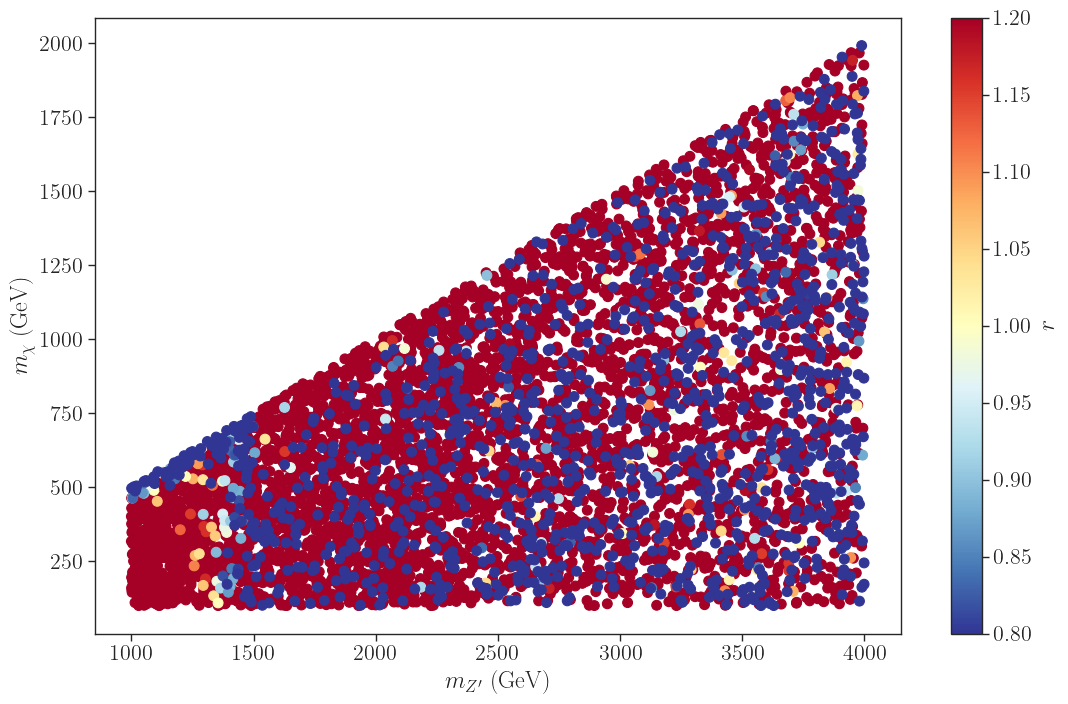

In [18]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))


x = dataDF['mass.9900032']
y = dataDF['mass.9000006']
c = dataDF['ExptRes.result0.r']

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
# plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
#          transform = plt.gca().transAxes)

# plt.legend()
plt.show()

In [19]:
dataDF['extpar.1'].unique()

array([1.414214, 2.      , 1.5     , 3.5     , 5.      , 3.      ,
       4.      , 2.5     , 4.5     ])

In [20]:
cmsCurve = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')

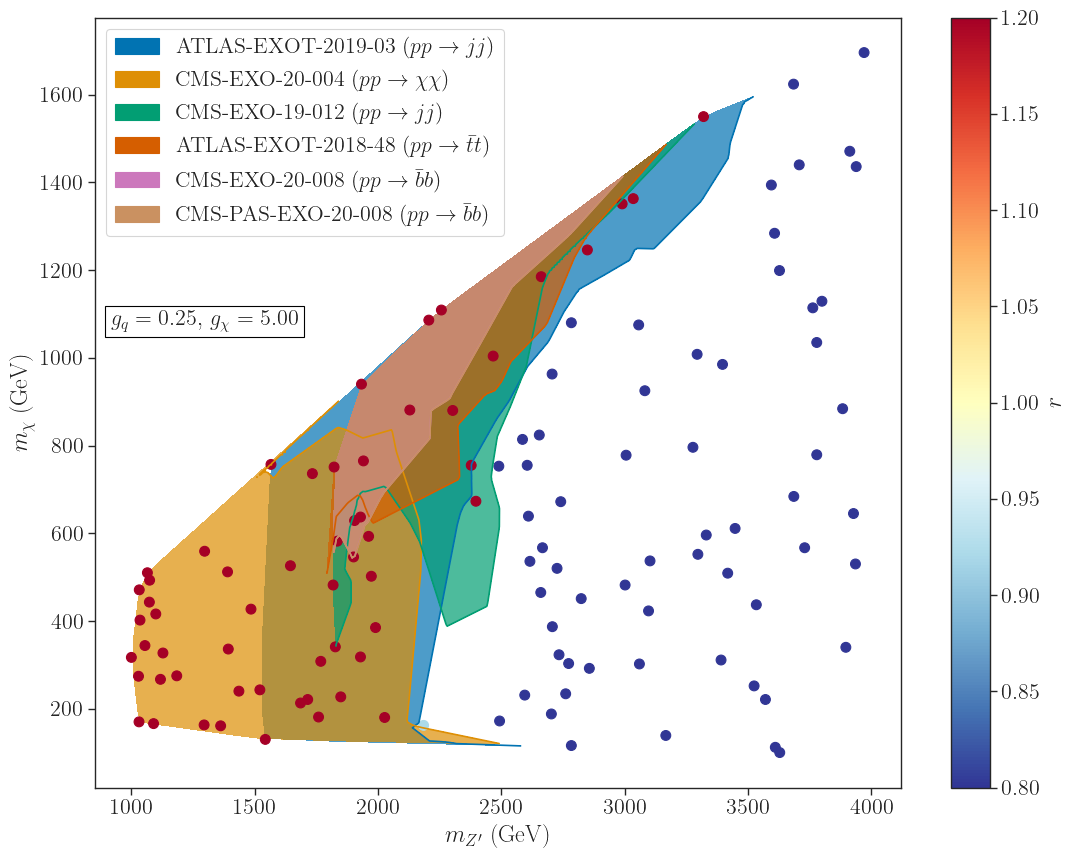

In [21]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,10))

gqv = 0.25
gchi = 5.0

x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)]
y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)]
c = dataDF['ExptRes.result0.r'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)]

for label in excluded['label'].unique():
#     if label != 'CMS-EXO-20-004 (TRV1)': continue
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.7, colors=colorDict[label])
    
    
plt.legend(handles=[legend[0], legend[1], legend[2], legend[3], legend[4], legend[5]])

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.02,0.6,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=16,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.xlim(990.0, 4010.0)
# plt.ylim(90.0,1800.0)

# plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')
# plt.legend()
plt.show()

In [22]:
dataDF[(dataDF['mass.9900032']>2000.0)&(dataDF['mass.9000006']<400)&(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)]

,filename,mass.9000006,mass.9900032,mass.9900026,width.9000006,width.9900026,width.9900032,extpar.1,extpar.2,extpar.3,...,ExptRes.result5.likelihood,ExptRes.result5.l_max,ExptRes.result5.l_SM,ExptRes.result1.likelihood,ExptRes.result1.l_max,ExptRes.result1.l_SM,ExptRes.result3.likelihood,ExptRes.result3.l_max,ExptRes.result3.l_SM,excludedLHC
3541,run_3994_zp_2027_dm_698.slha,180.0,2027.0,1013.5,0.0,81.35450,701.0362,5.0,0.25,0.0,...,NaN,NaN,NaN,4.914779e-277,1.136072e-275,1.793298e-276,NaN,NaN,NaN,True
2877,run_3813_zp_2185_dm_965.slha,162.0,2185.0,1092.5,0.0,97.70092,765.9246,5.0,0.25,0.0,...,NaN,NaN,NaN,5.883102e-276,1.108452e-275,1.793298e-276,NaN,NaN,NaN,False
5518,run_236_zp_2493_dm_499.slha,172.0,2493.0,1246.5,0.0,131.33830,877.5087,5.0,0.25,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3988,run_1441_zp_2595_dm_1174.slha,231.0,2595.0,1297.5,0.0,140.33460,897.2858,5.0,0.25,0.0,...,NaN,NaN,NaN,9.220193e-276,1.336422e-275,1.793298e-276,NaN,NaN,NaN,False
1101,run_3610_zp_2707_dm_1142.slha,387.0,2707.0,1353.5,0.0,141.52590,870.5599,5.0,0.25,0.0,...,NaN,NaN,NaN,6.415027e-276,1.022712e-275,1.793298e-276,NaN,NaN,NaN,False
5056,run_355_zp_2734_dm_816.slha,323.0,2734.0,1367.0,0.0,151.79820,913.2586,5.0,0.25,0.0,...,NaN,NaN,NaN,6.003966e-276,1.010076e-275,1.793298e-276,NaN,NaN,NaN,False
2315,run_1960_zp_2703_dm_669.slha,188.0,2703.0,1351.5,0.0,157.85190,951.0143,5.0,0.25,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5508,run_4046_zp_2773_dm_273.slha,303.0,2773.0,1386.5,0.0,159.31990,937.1269,5.0,0.25,0.0,...,NaN,NaN,NaN,5.437069e-276,9.839182e-276,1.793298e-276,NaN,NaN,NaN,False
3397,run_223_zp_2761_dm_888.slha,234.0,2761.0,1380.5,0.0,163.07820,958.6941,5.0,0.25,0.0,...,NaN,NaN,NaN,5.947129e-276,1.231352e-275,1.793298e-276,NaN,NaN,NaN,False
5905,run_445_zp_2784_dm_376.slha,116.0,2784.0,1392.0,0.0,172.84000,996.5774,5.0,0.25,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [23]:
dataDF.loc[[3541]]

,filename,mass.9000006,mass.9900032,mass.9900026,width.9000006,width.9900026,width.9900032,extpar.1,extpar.2,extpar.3,...,ExptRes.result5.likelihood,ExptRes.result5.l_max,ExptRes.result5.l_SM,ExptRes.result1.likelihood,ExptRes.result1.l_max,ExptRes.result1.l_SM,ExptRes.result3.likelihood,ExptRes.result3.l_max,ExptRes.result3.l_SM,excludedLHC
3541,run_3994_zp_2027_dm_698.slha,180.0,2027.0,1013.5,0.0,81.3545,701.0362,5.0,0.25,0.0,...,NaN,NaN,NaN,4.914779e-277,1.136072e-275,1.793298e-276,NaN,NaN,NaN,True


In [24]:
for column in dataDF.loc[[3541]]:
    print(column, dataDF.loc[[3541]][column].values)

filename ['run_3994_zp_2027_dm_698.slha']
mass.9000006 [180.]
mass.9900032 [2027.]
mass.9900026 [1013.5]
width.9000006 [0.]
width.9900026 [81.3545]
width.9900032 [701.0362]
extpar.1 [5.]
extpar.2 [0.25]
extpar.3 [0.]
extpar.4 [1.]
extpar.5 [1013.5]
extpar.6 [0.25]
extpar.7 [0.]
xsec13TeV(fb).9900032 [680.1]
BRs.sd.chi,chi [0.3795891]
BRs.sd.W-,W+ [0.2528649]
BRs.sd.higgs,higgs [0.204792]
BRs.sd.Z,Z [0.125006]
BRs.sd.t-,t+ [0.03774646]
BRs.zp.chi,chi [0.9137196]
BRs.zp.b,b [0.01438081]
BRs.zp.c,c [0.01438081]
BRs.zp.q,q [0.01438081]
BRs.zp.t-,t+ [0.0143763]
totalxsec13TeV(fb) [680.1]
totalxsec8TeV(fb) [0.]
Total xsec for missing topologies (fb) [0.]
Total xsec for missing topologies with displaced decays (fb) [0.]
Total xsec for missing topologies with prompt decays (fb) [58.67927]
Total xsec for topologies outside the grid (fb) [0.]
OutputStatus.sigmacut [0.]
OutputStatus.minmassgap [5.]
OutputStatus.maxcond [0.2]
OutputStatus.ncpus [1]
OutputStatus.model ['run_01_zp_3612_dm_1412_gqv_0

### Validate exclusion curve for CMS-EXO-20-004

In [25]:
cmsCurve = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')

In [26]:
## Get results with rescaled xsection that matches gchi = 1.0
pclFiles = ['../../data/smodels_results/2mdm_results_rescaled.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF_rescaled = pd.concat(dfs, ignore_index=True)

In [27]:
idCols = [c for c in dataDF_rescaled.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF_rescaled.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID']


In [28]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [29]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [30]:
filteredDF_rescaled = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF_rescaled.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF_rescaled.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF_rescaled.append(newrow)  

In [31]:
newDF_rescaled = pd.DataFrame.from_dict(filteredDF_rescaled)

In [32]:
labels = []
for index, row in newDF_rescaled.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF_rescaled['label'] = labels

In [33]:
colors = sns.color_palette("colorblind",len(excluded['label'].unique()))

colorDict = {}
for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)
    
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

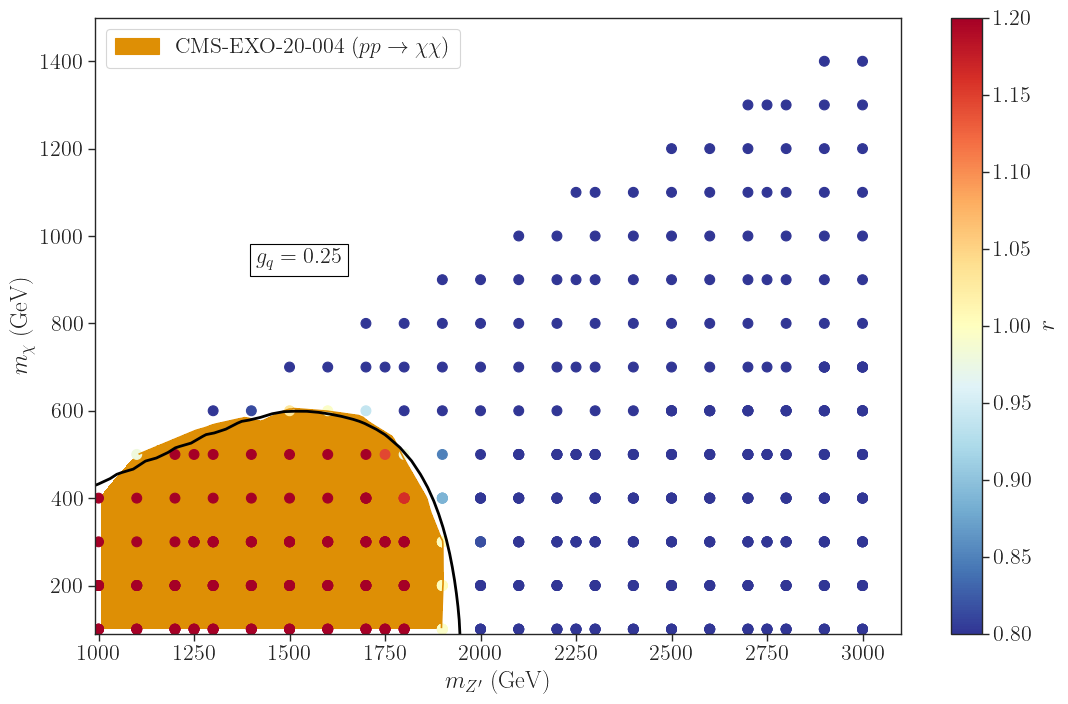

In [34]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

gqv = 0.25
curve = 'CMS-EXO-20-004'

x = newDF_rescaled['mass.9900032'][newDF_rescaled['ExptRes.result.AnalysisID'] == curve]
y = newDF_rescaled['mass.9000006'][newDF_rescaled['ExptRes.result.AnalysisID'] == curve]
c = newDF_rescaled['ExptRes.result.r'][newDF_rescaled['ExptRes.result.AnalysisID'] == curve]

data = newDF_rescaled[(newDF_rescaled['ExptRes.result.AnalysisID']==curve)]
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]

cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict['CMS-EXO-20-004 (TRV1)'])
plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], colors=colorDict['CMS-EXO-20-004 (TRV1)'])


plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)

plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')

plt.legend(handles=[legend[1]])

plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.xlim(990.0, 3100.0)
plt.ylim(90.0,1500.0)
plt.savefig('2mdm_validation.png')

plt.show()

### Scan over $\alpha$ 

In [102]:
#Merge with SModelS DataFrame
pclFiles = {'all': '../../data/2mdm_results_scan_alpha/all/results.pcl',
            'zp': '../../data/2mdm_results_scan_alpha/zp_only/results.pcl'}

dataDF = pd.DataFrame()
for label, f in pclFiles.items():
    df = pd.read_pickle(f)
    df['process'] = label
    dataDF = pd.concat((dataDF, df))

In [103]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

In [104]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]

In [105]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [106]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [107]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [108]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [110]:
labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')


In [118]:
dfAll = newDF[(newDF['process']=='all')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [119]:
# dfAll = dfAll[dfAll['ExptRes.result.r']>=0.4]

In [120]:
dfZp = newDF[(newDF['process']=='zp')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]
# dfZp = dfZp[dfZp['ExptRes.result.r']>=0.4]

In [121]:
dfAll = dfAll.drop_duplicates(subset='filename')

In [122]:
mCols = ['mass.9900026', 'mass.9000006']
keys = list(dfAll[mCols].columns.values)
i1 = dfAll.set_index(keys).index
i2 = dfZp.set_index(keys).index
dfAll = dfAll[i1.isin(i2)]
dfZp = dfZp[i2.isin(i1)]

print(len(dfAll), len(dfZp))

143 143


In [44]:
dfAll = dfAll.sort_values(by=['mass.9900026', 'extpar.6'])
dfZp = dfZp.sort_values(by=['mass.9900026','extpar.6'])

In [45]:
dfAll['ExptRes.result.r'][(dfAll['mass.9900026'] == 500)&(dfAll['extpar.6']==1.0)]

294    0.050667
Name: ExptRes.result.r, dtype: float64

In [46]:
dfZp['ExptRes.result.r'][(dfZp['mass.9900026'] == 500)&(dfZp['extpar.6']==1.0)]

288    0.050667
Name: ExptRes.result.r, dtype: float64

In [47]:
r_diff = np.abs(np.array(dfAll['ExptRes.result.r']) - np.array(dfZp['ExptRes.result.r']))/np.array(dfAll['ExptRes.result.r'])

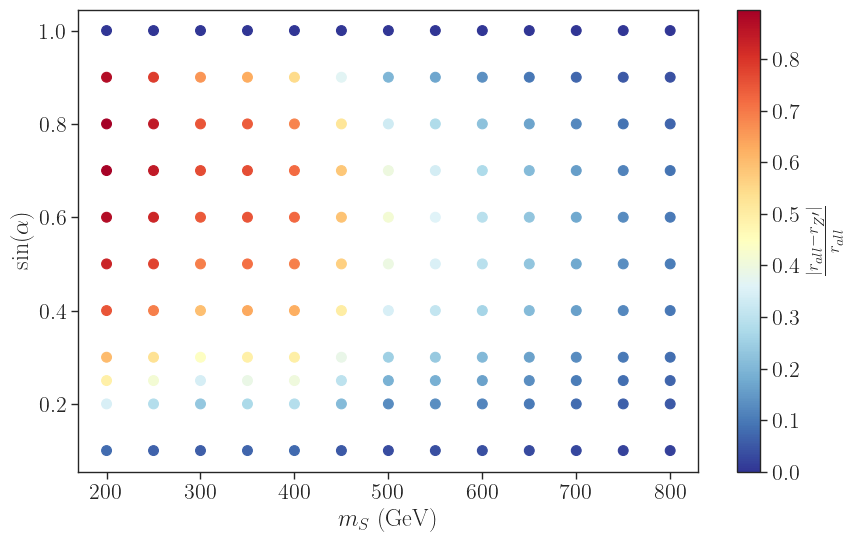

In [48]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))

x = dfAll['mass.9900026']
y = dfAll['extpar.6']
c = r_diff

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$\frac{|r_{all} - r_{Z^{\prime}}|}{r_{all}}$')

plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()